In [1]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
import requests
import os
import json
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from path import Path
from newsapi import NewsApiClient
import spacy
from spacy import displacy
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from newsapi import NewsApiClient

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re
import spacy
from spacy import displacy
from collections import Counter
from nltk import ngrams
%matplotlib inline


%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1. Qualitative Analysis - taking NewsAPI articles on the Canadian Housing Market 

Use the [newsapi](https://newsapi.org/) to pull the latest news articles for the Canadian Housing Market

In [2]:
# Read your api key environment variable
# Load environment variables and retrieve the News API key
load_dotenv()
api_key = os.getenv("NEWS_API_KEY")

In [3]:
# Create the newsapi client
newsapi = NewsApiClient(api_key=api_key)
natural_processing = spacy.load('en_core_web_sm')

In [4]:
# Fetch Canadian Housing Market
housingmarket_news_en = newsapi.get_everything(q="Canadian Housing Market",
                                               language="en",
                                               sort_by='relevancy'
)

# Show the total number of news
print(f"Total articles about Housing Market: {housingmarket_news_en['totalResults']}")

Total articles about Housing Market: 246


In [5]:
# Create the Bitcoin sentiment scores DataFrame
canhm_sentiments = []
for article in housingmarket_news_en["articles"]:
    try:
        text = article["content"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        # append each element of each iteration to the btc_sentiments empty list
        
        canhm_sentiments.append({
            "text": text,
            "date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu
        })
    except AttributeError:
        pass
    
canhm_sentiments_df = pd.DataFrame(canhm_sentiments)
cols = ["date", "text", "compound", "positive", "negative", "neutral"]
canhm_sentiments_df = canhm_sentiments_df[cols]

canhm_sentiments_df.head()

,date,text,compound,positive,negative,neutral
0,2021-11-16,* Canadian dollar weakens 0.2% against the gre...,-0.3182,0.000,0.071,0.929
1,2021-12-07,"BENGALURU, Dec 7 (Reuters) - Canada's double-d...",-0.5710,0.061,0.163,0.775
2,2021-11-24,"OTTAWA, Nov 24 (Reuters) - Canadian housing pr...",-0.2732,0.077,0.130,0.793
3,2021-11-16,"(Adds analyst quotes and details throughout, u...",-0.3182,0.000,0.073,0.927
4,2021-12-02,Reuters polls experts on the outlook for major...,0.3612,0.077,0.000,0.923


In [6]:
canhm_sentiments_df.describe() ######Add Heatmap like gaph

,compound,positive,negative,neutral
count,20.000000,20.000000,20.000000,20.000000
mean,0.115725,0.068050,0.040300,0.891600
std,0.456127,0.061921,0.062357,0.067224
min,-0.680800,0.000000,0.000000,0.775000
25%,-0.284450,0.000000,0.000000,0.836750
50%,0.272250,0.077000,0.000000,0.902000
75%,0.396450,0.089000,0.071500,0.927500
max,0.709600,0.177000,0.167000,1.000000


### Tokenizer

In [7]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
sw = set(stopwords.words('english'))

# Expand the default stopwords list if necessary
stopwords_addons = {'said', 'sent', 'found', 'canadian', 'reuters', 'market','including','new', 'picture', 'today', 'announced', 'week', 'basically', 'also', 'chars', '\r\n'}

In [8]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    
    # Remove the punctuation from text
    
    words = nltk.word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha()]
    str_words = ' '.join(str(e) for e in words)
    
    # Create a tokenized list of the words
    
    doc = natural_processing(str_words)
    doc_words = ' '.join(str(e) for e in doc)
    tok = word_tokenize(doc_words)
    result = [word.lower() for word in tok]
    lemma_words = ' '.join(str(e) for e in result)
    
    # Lemmatize words into root words
    
    lemma_result = lemmatizer.lemmatize(lemma_words)
   
    # Convert the words to lowercase
    
    lower_result = [lemma_result.lower() for word in lemma_result]
    re_words = ' '.join(str(e) for e in lower_result)
    
    # Remove the stop words
    
    re_words = word_tokenize(re_words)
    tokens = [word.lower() for word in re_words if word.lower() not in sw.union(stopwords_addons)]
    
    
    return tokens

In [9]:

canhm_sentiments_df = canhm_sentiments_df.set_index('date')

In [10]:
# Create a new tokens column for Canadian Housing Market

canhm_sentiments_df["tokens"] = canhm_sentiments_df["text"].apply(tokenizer)
canhm_sentiments_df.head() ###Change it to datetime

,text,compound,positive,negative,neutral,tokens
date,,,,,,
2021-11-16,* Canadian dollar weakens 0.2% against the gre...,-0.3182,0.000,0.071,0.929,"[dollar, weakens, greenback, loonie, trades, r..."
2021-12-07,"BENGALURU, Dec 7 (Reuters) - Canada's double-d...",-0.5710,0.061,0.163,0.775,"[bengaluru, dec, canada, house, price, inflati..."
2021-11-24,"OTTAWA, Nov 24 (Reuters) - Canadian housing pr...",-0.2732,0.077,0.130,0.793,"[ottawa, nov, housing, prices, set, surge, com..."
2021-11-16,"(Adds analyst quotes and details throughout, u...",-0.3182,0.000,0.073,0.927,"[adds, analyst, quotes, details, throughout, u..."
2021-12-02,Reuters polls experts on the outlook for major...,0.3612,0.077,0.000,0.923,"[polls, experts, outlook, major, world, econom..."


<AxesSubplot:xlabel='date'>

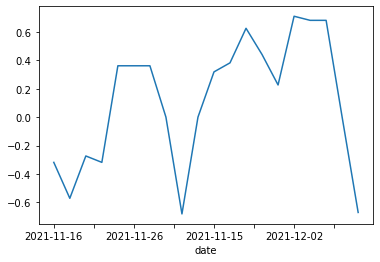

In [11]:
canhm_sentiments_df['compound'].plot() ####why the date is not showing fully ?!

<AxesSubplot:xlabel='date'>

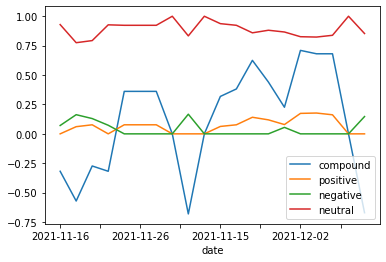

In [12]:
canhm_sentiments_df.plot()

In [13]:
# Generate the Bitcoin N-grams where N=2
canhm_grams = ngrams(tokenizer(canhm_sentiments_df["text"].str.cat()), n=2)
Counter(canhm_grams).most_common(20)

[(('updates', 'prices'), 14588),
 (('stock', 'markets'), 14588),
 (('real', 'estate'), 14588),
 (('dollar', 'weakens'), 10941),
 (('weakens', 'greenback'), 10941),
 (('throughout', 'updates'), 10941),
 (('polls', 'experts'), 10941),
 (('experts', 'outlook'), 10941),
 (('outlook', 'major'), 10941),
 (('major', 'world'), 10941),
 (('world', 'economies'), 10941),
 (('economies', 'central'), 10941),
 (('central', 'bank'), 10941),
 (('bank', 'policy'), 10941),
 (('policy', 'foreign'), 10941),
 (('foreign', 'exchange'), 10941),
 (('exchange', 'rates'), 10941),
 (('rates', 'stock'), 10941),
 (('markets', 'money'), 10941),
 (('money', 'bond'), 10941)]

In [14]:
# Function token_count generates the top 10 words for a subject
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [15]:
# Use token_count to get the top 10 words for Canadian Housing MArket
canhm_all = tokenizer(canhm_sentiments_df["text"].str.cat())
result_top25_canhm = token_count(canhm_all, 25)
print(result_top25_canhm)

[('housing', 29176), ('markets', 29176), ('prices', 29176), ('rates', 21882), ('nov', 18235), ('bank', 18235), ('stock', 18235), ('dollar', 14588), ('world', 14588), ('updates', 14588), ('real', 14588), ('estate', 14588), ('weakens', 10941), ('greenback', 10941), ('adds', 10941), ('throughout', 10941), ('polls', 10941), ('experts', 10941), ('outlook', 10941), ('major', 10941), ('economies', 10941), ('central', 10941), ('policy', 10941), ('foreign', 10941), ('exchange', 10941)]


In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [25.0, 12.0]

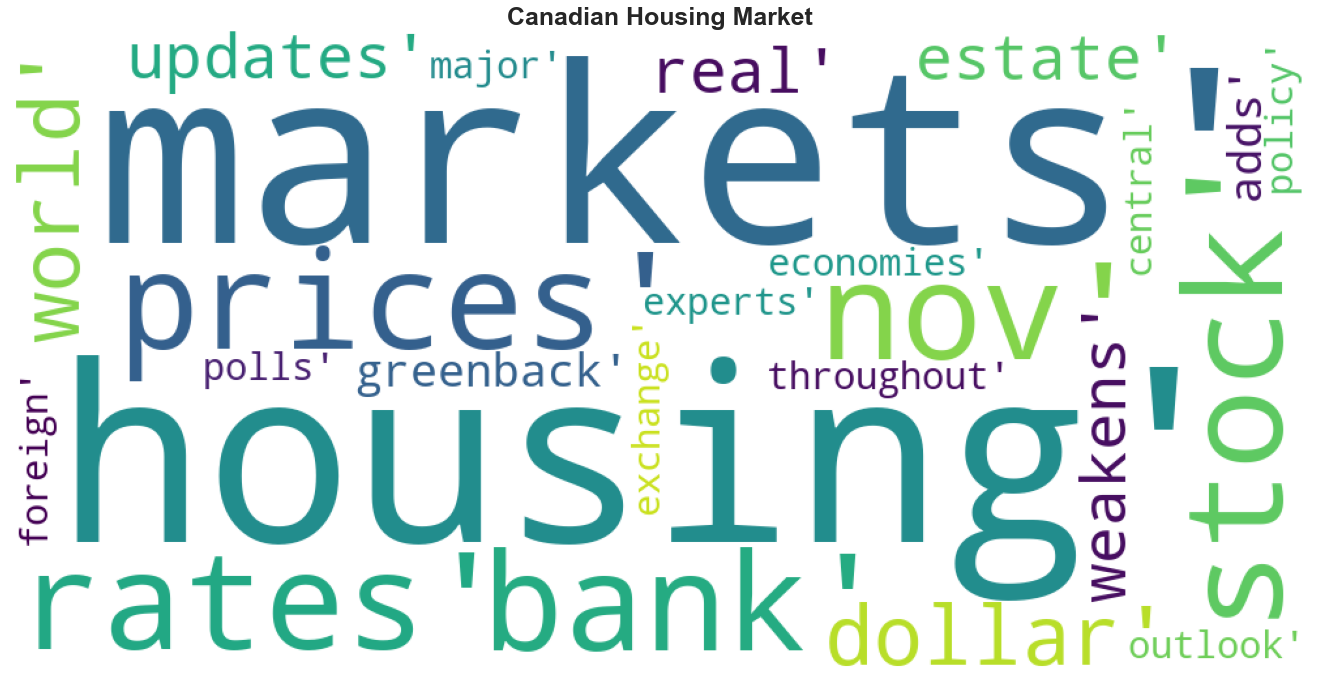

In [17]:
# Generate the Canadian Housing Market word cloud
terms_list_canhm = str(result_top25_canhm)

# Create the word cloud
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(terms_list_canhm)
plt.imshow(wordcloud)
plt.axis("off")
fontdict = {"fontsize": 25, "fontweight": "bold"}
plt.title("Canadian Housing Market", fontdict=fontdict)
plt.imshow(wordcloud)

## 2. Qualitative Analysis - taking Twitter articles on the Canadian Housing Market 

Use the Twitter APIv2 to pull the latest news articles for the Canadian Housing Market

In [20]:
import requests
import os
import json

# To set your environment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
bearer_token = os.getenv("twitter_bearer_token")

search_url = "https://api.twitter.com/2/tweets/search/recent"
 

# Optional params: start_time,end_time,since_id,until_id,max_results,next_token,
# expansions,tweet.fields,media.fields,poll.fields,place.fields,user.fields
query_params = {'query': '("Canadian Housing Market") -"recent search" OR #twitterdev','tweet.fields': 'author_id'}


In [21]:
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()


def main():
    json_response = connect_to_endpoint(search_url, query_params)
    print(json.dumps(json_response, indent=4, sort_keys=True))


if __name__ == "__main__":
    main()

200
{
    "data": [
        {
            "author_id": "1196170793085890561",
            "id": "1468033399869034497",
            "text": "RT @DonatoBardi: @SteveSaretsky More fuel for the Canadian housing market: https://t.co/nuYB1v3hnZ"
        },
        {
            "author_id": "1334327906735017985",
            "id": "1468023197203193856",
            "text": "RT @gauloics: Sabar, jik proses\n\n#TwitterApi\n#TwitterDev\n#pipedream\n#TelegramTips https://t.co/ZNzRlXjwKh"
        },
        {
            "author_id": "1291101546478886912",
            "id": "1468023082925248515",
            "text": "RT @gauloics: Sabar, jik proses\n\n#TwitterApi\n#TwitterDev\n#pipedream\n#TelegramTips https://t.co/ZNzRlXjwKh"
        },
        {
            "author_id": "44820785",
            "id": "1468022999248891907",
            "text": "RT @gauloics: Sabar, jik proses\n\n#TwitterApi\n#TwitterDev\n#pipedream\n#TelegramTips https://t.co/ZNzRlXjwKh"
        },
        {
            "author_i

In [ ]:
# import requests
# import os
# import json

# # To set your environment variables in your terminal run the following line:
# # export 'BEARER_TOKEN'='<your_bearer_token>'
# bearer_token = os.environ.get("BEARER_TOKEN")

# search_url = "https://api.twitter.com/2/tweets/search/all"

# # Optional params: start_time,end_time,since_id,until_id,max_results,next_token,
# # expansions,tweet.fields,media.fields,poll.fields,place.fields,user.fields
# query_params = {'query': '("Canada") OR #twitterdev','tweet.fields': 'author_id'}

In [ ]:
# def bearer_oauth(r):
#     """
#     Method required by bearer token authentication.
#     """

#     r.headers["Authorization"] = f"Bearer {bearer_token}"
#     r.headers["User-Agent"] = "v2FullArchiveSearchPython"
#     return r


# def connect_to_endpoint(url, params):
#     response = requests.request("GET", search_url, auth=bearer_oauth, params=params)
#     print(response.status_code)
#     if response.status_code != 200:
#         raise Exception(response.status_code, response.text)
#     return response.json()


# def main():
#     json_response = connect_to_endpoint(search_url, query_params)
#     print(json.dumps(json_response, indent=4, sort_keys=True))


# if __name__ == "__main__":
#     main()